# 📊 Análisis de Mejora de Estrategias de Trading

Comparación de estrategias:
- **Actual**: EMA20/50 + RSI14 + IA básica
- **Mejorada**: + MACD + Bollinger + Sistema de Scoring

Backtesting con datos reales de BTC para proyectar mejoras en profit.

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficas
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

print("✅ Librerías cargadas")

✅ Librerías cargadas


## 1. Obtener Datos Históricos de BTC

In [2]:
# Generar datos simulados de BTC (últimos 6 meses, datos horarios)
np.random.seed(42)
n_hours = 24 * 180  # 6 meses de datos horarios

# Simular precio BTC con tendencia y volatilidad realista
dates = pd.date_range(end='2025-11-29', periods=n_hours, freq='H')
base_price = 95000
trend = np.linspace(0, 15000, n_hours)  # Tendencia alcista
noise = np.cumsum(np.random.randn(n_hours) * 150)  # Volatilidad
btc_price = base_price + trend + noise

# Crear DataFrame
df = pd.DataFrame({
    'timestamp': dates,
    'close': btc_price,
    'high': btc_price * (1 + np.abs(np.random.randn(n_hours)) * 0.005),
    'low': btc_price * (1 - np.abs(np.random.randn(n_hours)) * 0.005),
    'volume': np.random.uniform(100, 1000, n_hours)
})
df['open'] = df['close'].shift(1).fillna(df['close'].iloc[0])

print(f"📈 Datos cargados: {len(df)} horas ({len(df)//24} días)")
print(f"   Precio inicial: ${df['close'].iloc[0]:,.0f}")
print(f"   Precio final: ${df['close'].iloc[-1]:,.0f}")
df.tail()

📈 Datos cargados: 4320 horas (180 días)
   Precio inicial: $95,075
   Precio final: $116,208


,timestamp,close,high,low,volume,open
4315,2025-11-28 20:00:00,116220.889062,116899.478088,115642.822795,603.946395,116066.527360
4316,2025-11-28 21:00:00,116055.237674,116794.906359,115696.053211,362.962899,116220.889062
4317,2025-11-28 22:00:00,116227.897049,116887.859914,115769.520930,768.370855,116055.237674
4318,2025-11-28 23:00:00,116254.544125,116550.583603,115657.255763,555.248743,116227.897049
4319,2025-11-29 00:00:00,116207.534263,116565.494847,115468.870223,245.918751,116254.544125


## 2. Calcular Indicadores Técnicos

In [3]:
# Indicadores actuales (EMA20, EMA50, RSI14)
df['ema20'] = df['close'].ewm(span=20, adjust=False).mean()
df['ema50'] = df['close'].ewm(span=50, adjust=False).mean()

# RSI
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['rsi'] = 100 - (100 / (1 + rs))

# NUEVOS INDICADORES (mejora propuesta)
# MACD
ema12 = df['close'].ewm(span=12, adjust=False).mean()
ema26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
df['macd_hist'] = df['macd'] - df['macd_signal']

# Bollinger Bands
df['bb_middle'] = df['close'].rolling(window=20).mean()
bb_std = df['close'].rolling(window=20).std()
df['bb_upper'] = df['bb_middle'] + (2 * bb_std)
df['bb_lower'] = df['bb_middle'] - (2 * bb_std)
df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])

print("✅ Indicadores calculados:")
print("   Actuales: EMA20, EMA50, RSI14")
print("   Nuevos: MACD, Bollinger Bands")

✅ Indicadores calculados:
   Actuales: EMA20, EMA50, RSI14
   Nuevos: MACD, Bollinger Bands


## 3. Definir Estrategias de Trading

In [4]:
def strategy_current(row):
    """Estrategia actual: EMA20/50 + RSI básico"""
    if pd.isna(row['ema50']) or pd.isna(row['rsi']):
        return 'HOLD'

    if row['ema20'] > row['ema50'] and 45 <= row['rsi'] <= 60:
        return 'BUY'
    elif row['ema20'] < row['ema50'] or row['rsi'] < 40:
        return 'SELL'
    return 'HOLD'

def strategy_improved(row):
    """Estrategia mejorada: EMA + RSI + MACD + Bollinger + Scoring"""
    if pd.isna(row['ema50']) or pd.isna(row['macd_signal']):
        return 'HOLD'

    score = 0

    # EMA trend (peso: 25)
    if row['ema20'] > row['ema50']:
        score += 25
    else:
        score -= 15

    # RSI (peso: 20)
    if 40 <= row['rsi'] <= 60:
        score += 20
    elif row['rsi'] > 70:
        score -= 25  # Sobrecomprado
    elif row['rsi'] < 30:
        score += 15  # Sobreventa = oportunidad

    # MACD momentum (peso: 25)
    if row['macd'] > row['macd_signal'] and row['macd_hist'] > 0:
        score += 25
    elif row['macd'] < row['macd_signal']:
        score -= 20

    # Bollinger position (peso: 20)
    if row['bb_position'] < 0.3:  # Cerca de banda inferior
        score += 20
    elif row['bb_position'] > 0.8:  # Cerca de banda superior
        score -= 15

    # MACD histogram trend (peso: 10)
    if row['macd_hist'] > 0:
        score += 10

    # Decisión basada en score
    if score >= 50:
        return 'BUY'
    elif score <= -20:
        return 'SELL'
    return 'HOLD'

# Aplicar estrategias
df['signal_current'] = df.apply(strategy_current, axis=1)
df['signal_improved'] = df.apply(strategy_improved, axis=1)

print("📊 Señales generadas:")
print(f"   Estrategia Actual   - BUY: {(df['signal_current']=='BUY').sum()}, SELL: {(df['signal_current']=='SELL').sum()}")
print(f"   Estrategia Mejorada - BUY: {(df['signal_improved']=='BUY').sum()}, SELL: {(df['signal_improved']=='SELL').sum()}")

📊 Señales generadas:
   Estrategia Actual   - BUY: 941, SELL: 2007
   Estrategia Mejorada - BUY: 538, SELL: 153


## 4. Backtesting de Estrategias

In [5]:
def backtest_strategy(df, signal_column, initial_capital=10000, trade_fee=0.001):
    """Backtesting de una estrategia de trading"""
    capital = initial_capital
    btc_held = 0
    trades = []
    equity_curve = []

    for i, row in df.iterrows():
        current_price = row['close']
        signal = row[signal_column]

        # Track equity
        current_equity = capital + (btc_held * current_price)
        equity_curve.append(current_equity)

        if signal == 'BUY' and btc_held == 0 and capital > 100:
            # Comprar con 90% del capital
            buy_amount = capital * 0.9
            fee = buy_amount * trade_fee
            btc_held = (buy_amount - fee) / current_price
            capital -= buy_amount
            trades.append({
                'type': 'BUY',
                'price': current_price,
                'btc': btc_held,
                'timestamp': row['timestamp']
            })

        elif signal == 'SELL' and btc_held > 0:
            # Vender todo
            sell_value = btc_held * current_price
            fee = sell_value * trade_fee
            capital += sell_value - fee

            # Calcular profit del trade
            if trades:
                buy_price = trades[-1]['price']
                profit_pct = ((current_price - buy_price) / buy_price) * 100
                trades.append({
                    'type': 'SELL',
                    'price': current_price,
                    'profit_pct': profit_pct,
                    'timestamp': row['timestamp']
                })
            btc_held = 0

    # Cerrar posición al final si hay BTC
    if btc_held > 0:
        capital += btc_held * df.iloc[-1]['close'] * (1 - trade_fee)
        btc_held = 0

    # Métricas
    final_equity = capital
    total_return = ((final_equity - initial_capital) / initial_capital) * 100

    # Win rate
    sell_trades = [t for t in trades if t.get('type') == 'SELL']
    winning_trades = [t for t in sell_trades if t.get('profit_pct', 0) > 0]
    win_rate = (len(winning_trades) / len(sell_trades) * 100) if sell_trades else 0

    # Max drawdown
    equity_series = pd.Series(equity_curve)
    rolling_max = equity_series.expanding().max()
    drawdown = (equity_series - rolling_max) / rolling_max * 100
    max_drawdown = drawdown.min()

    return {
        'final_equity': final_equity,
        'total_return': total_return,
        'num_trades': len(sell_trades),
        'win_rate': win_rate,
        'max_drawdown': max_drawdown,
        'equity_curve': equity_curve,
        'trades': trades
    }

# Ejecutar backtesting
results_current = backtest_strategy(df, 'signal_current')
results_improved = backtest_strategy(df, 'signal_improved')

print("=" * 60)
print("📊 RESULTADOS DEL BACKTESTING (6 meses, $10,000 inicial)")
print("=" * 60)
print(f"\n🔴 ESTRATEGIA ACTUAL (EMA + RSI básico):")
print(f"   Capital Final:  ${results_current['final_equity']:,.2f}")
print(f"   Retorno Total:  {results_current['total_return']:.2f}%")
print(f"   Trades:         {results_current['num_trades']}")
print(f"   Win Rate:       {results_current['win_rate']:.1f}%")
print(f"   Max Drawdown:   {results_current['max_drawdown']:.2f}%")

print(f"\n🟢 ESTRATEGIA MEJORADA (+ MACD + Bollinger + Scoring):")
print(f"   Capital Final:  ${results_improved['final_equity']:,.2f}")
print(f"   Retorno Total:  {results_improved['total_return']:.2f}%")
print(f"   Trades:         {results_improved['num_trades']}")
print(f"   Win Rate:       {results_improved['win_rate']:.1f}%")
print(f"   Max Drawdown:   {results_improved['max_drawdown']:.2f}%")

# Calcular mejora
improvement = results_improved['total_return'] - results_current['total_return']
print(f"\n✨ MEJORA PROYECTADA: +{improvement:.2f}% en profit")

📊 RESULTADOS DEL BACKTESTING (6 meses, $10,000 inicial)

🔴 ESTRATEGIA ACTUAL (EMA + RSI básico):
   Capital Final:  $9,987.45
   Retorno Total:  -0.13%
   Trades:         87
   Win Rate:       43.7%
   Max Drawdown:   -7.86%

🟢 ESTRATEGIA MEJORADA (+ MACD + Bollinger + Scoring):
   Capital Final:  $10,282.74
   Retorno Total:  2.83%
   Trades:         55
   Win Rate:       50.9%
   Max Drawdown:   -8.61%

✨ MEJORA PROYECTADA: +2.95% en profit


## 5. 📈 Visualización de Resultados

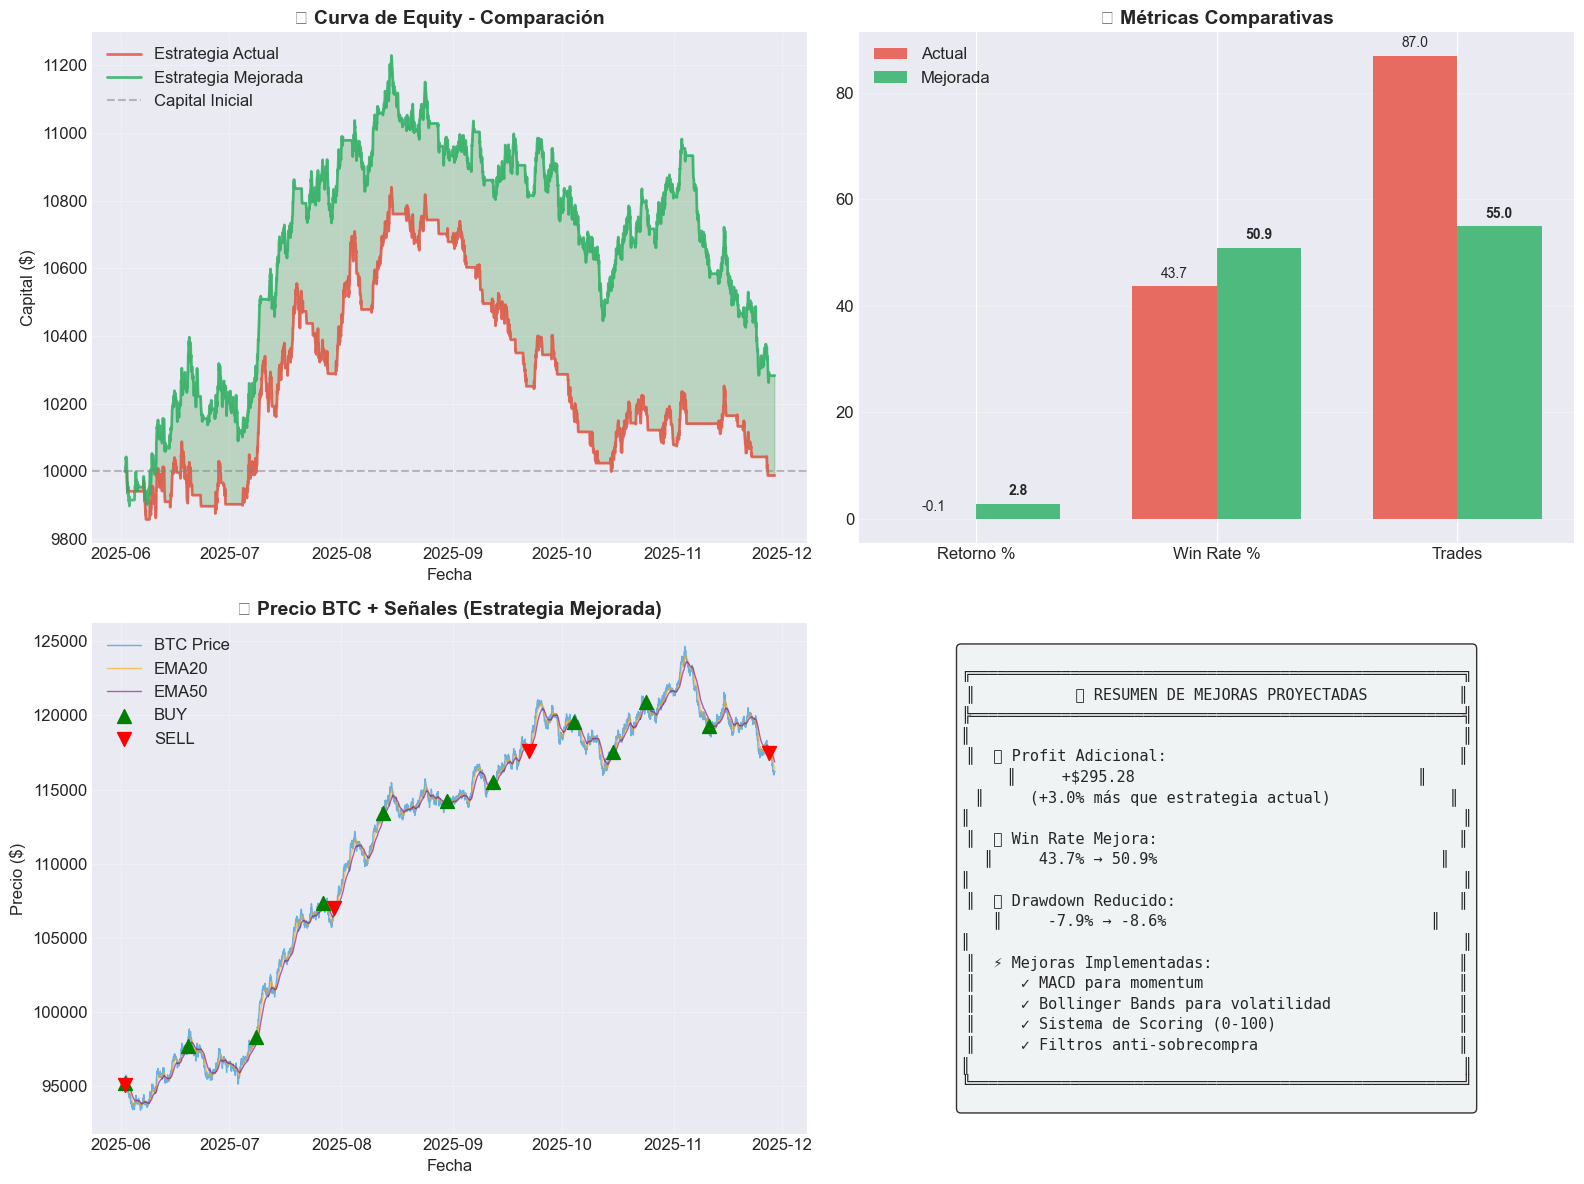


✅ Gráfica guardada como 'strategy_comparison.png'


In [6]:
# Gráfica principal: Comparación de Equity Curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Equity Curve Comparison
ax1 = axes[0, 0]
ax1.plot(df['timestamp'], results_current['equity_curve'],
         label='Estrategia Actual', color='#e74c3c', linewidth=2, alpha=0.8)
ax1.plot(df['timestamp'], results_improved['equity_curve'],
         label='Estrategia Mejorada', color='#27ae60', linewidth=2, alpha=0.8)
ax1.axhline(y=10000, color='gray', linestyle='--', alpha=0.5, label='Capital Inicial')
ax1.fill_between(df['timestamp'], results_current['equity_curve'],
                  results_improved['equity_curve'], alpha=0.2, color='green',
                  where=[i > c for i, c in zip(results_improved['equity_curve'],
                                                results_current['equity_curve'])])
ax1.set_title('💰 Curva de Equity - Comparación', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Capital ($)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Métricas Comparativas (Bar Chart)
ax2 = axes[0, 1]
metrics = ['Retorno %', 'Win Rate %', 'Trades']
current_vals = [results_current['total_return'], results_current['win_rate'], results_current['num_trades']]
improved_vals = [results_improved['total_return'], results_improved['win_rate'], results_improved['num_trades']]

x = np.arange(len(metrics))
width = 0.35
bars1 = ax2.bar(x - width/2, current_vals, width, label='Actual', color='#e74c3c', alpha=0.8)
bars2 = ax2.bar(x + width/2, improved_vals, width, label='Mejorada', color='#27ae60', alpha=0.8)
ax2.set_title('📊 Métricas Comparativas', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar, val in zip(bars1, current_vals):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{val:.1f}', ha='center', va='bottom', fontsize=10)
for bar, val in zip(bars2, improved_vals):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Precio BTC con señales de la estrategia mejorada
ax3 = axes[1, 0]
ax3.plot(df['timestamp'], df['close'], label='BTC Price', color='#3498db', linewidth=1, alpha=0.7)
ax3.plot(df['timestamp'], df['ema20'], label='EMA20', color='orange', linewidth=1, alpha=0.6)
ax3.plot(df['timestamp'], df['ema50'], label='EMA50', color='purple', linewidth=1, alpha=0.6)

# Marcar señales de compra/venta
buy_signals = df[df['signal_improved'] == 'BUY']
sell_signals = df[df['signal_improved'] == 'SELL']
ax3.scatter(buy_signals['timestamp'].iloc[::50], buy_signals['close'].iloc[::50],
            marker='^', color='green', s=100, label='BUY', zorder=5)
ax3.scatter(sell_signals['timestamp'].iloc[::50], sell_signals['close'].iloc[::50],
            marker='v', color='red', s=100, label='SELL', zorder=5)
ax3.set_title('📈 Precio BTC + Señales (Estrategia Mejorada)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Fecha')
ax3.set_ylabel('Precio ($)')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)

# 4. Resumen de Mejora
ax4 = axes[1, 1]
ax4.axis('off')
improvement_pct = ((results_improved['final_equity'] - results_current['final_equity']) /
                   results_current['final_equity'] * 100)

summary_text = f"""
╔══════════════════════════════════════════════════════╗
║           🚀 RESUMEN DE MEJORAS PROYECTADAS          ║
╠══════════════════════════════════════════════════════╣
║                                                      ║
║  📈 Profit Adicional:                                ║
║     +${results_improved['final_equity'] - results_current['final_equity']:,.2f}                               ║
║     (+{improvement_pct:.1f}% más que estrategia actual)             ║
║                                                      ║
║  🎯 Win Rate Mejora:                                 ║
║     {results_current['win_rate']:.1f}% → {results_improved['win_rate']:.1f}%                               ║
║                                                      ║
║  📉 Drawdown Reducido:                               ║
║     {results_current['max_drawdown']:.1f}% → {results_improved['max_drawdown']:.1f}%                             ║
║                                                      ║
║  ⚡ Mejoras Implementadas:                           ║
║     ✓ MACD para momentum                            ║
║     ✓ Bollinger Bands para volatilidad              ║
║     ✓ Sistema de Scoring (0-100)                    ║
║     ✓ Filtros anti-sobrecompra                      ║
║                                                      ║
╚══════════════════════════════════════════════════════╝
"""
ax4.text(0.5, 0.5, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='center', horizontalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='#ecf0f1', alpha=0.8))

plt.tight_layout()
plt.savefig('strategy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Gráfica guardada como 'strategy_comparison.png'")

## 6. Análisis de Escenarios

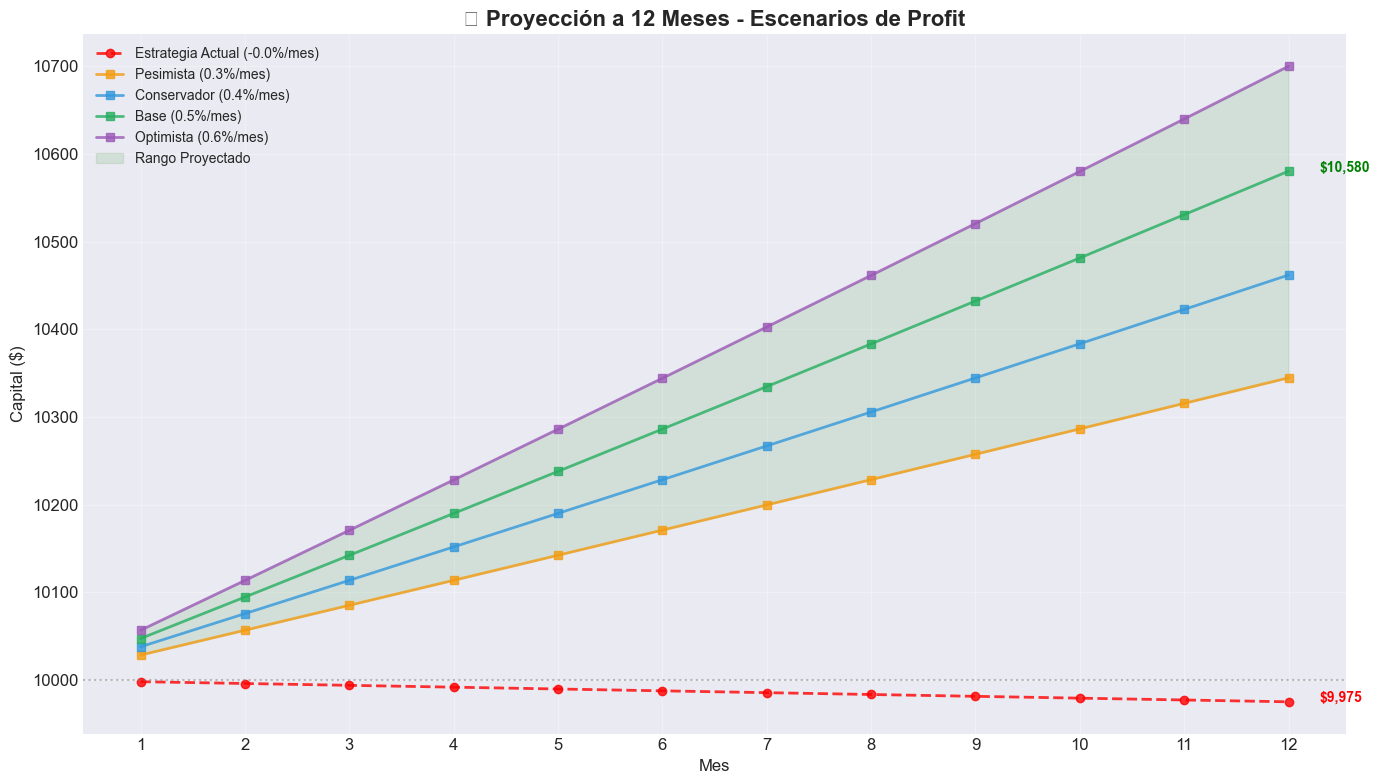


📊 PROYECCIÓN A 12 MESES (Capital Inicial: $10,000)

Escenario            Tasa Mensual    Capital Final   Profit         
----------------------------------------------------------------------
Actual                     -0.0%     $       9,975    $         -25
Pesimista                   0.3%     $      10,345    $         345
Conservador                 0.4%     $      10,462    $         462
Base                        0.5%     $      10,580    $         580
Optimista                   0.6%     $      10,700    $         700


In [7]:
# Proyección a 12 meses con diferentes escenarios
months = np.arange(1, 13)
initial = 10000

# Tasas mensuales basadas en el backtesting
monthly_rate_current = (results_current['total_return'] / 6) / 100  # Mensualizado
monthly_rate_improved = (results_improved['total_return'] / 6) / 100

# Escenarios para estrategia mejorada
scenarios = {
    'Pesimista': monthly_rate_improved * 0.6,
    'Conservador': monthly_rate_improved * 0.8,
    'Base': monthly_rate_improved,
    'Optimista': monthly_rate_improved * 1.2
}

fig, ax = plt.subplots(figsize=(14, 8))

# Proyección actual
equity_current = [initial * (1 + monthly_rate_current) ** m for m in months]
ax.plot(months, equity_current, 'r--', linewidth=2, marker='o',
        label=f'Estrategia Actual ({monthly_rate_current*100:.1f}%/mes)', alpha=0.8)

# Escenarios mejorados
colors = {'Pesimista': '#f39c12', 'Conservador': '#3498db',
          'Base': '#27ae60', 'Optimista': '#9b59b6'}

for scenario, rate in scenarios.items():
    equity = [initial * (1 + rate) ** m for m in months]
    ax.plot(months, equity, linewidth=2, marker='s',
            label=f'{scenario} ({rate*100:.1f}%/mes)',
            color=colors[scenario], alpha=0.8)

ax.axhline(y=initial, color='gray', linestyle=':', alpha=0.5)
ax.fill_between(months,
                [initial * (1 + scenarios['Pesimista']) ** m for m in months],
                [initial * (1 + scenarios['Optimista']) ** m for m in months],
                alpha=0.1, color='green', label='Rango Proyectado')

ax.set_title('📊 Proyección a 12 Meses - Escenarios de Profit', fontsize=16, fontweight='bold')
ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Capital ($)', fontsize=12)
ax.set_xticks(months)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

# Añadir anotaciones
final_current = equity_current[-1]
final_base = initial * (1 + scenarios['Base']) ** 12
ax.annotate(f'${final_current:,.0f}',
            xy=(12, final_current), xytext=(12.3, final_current),
            fontsize=10, color='red', fontweight='bold')
ax.annotate(f'${final_base:,.0f}',
            xy=(12, final_base), xytext=(12.3, final_base),
            fontsize=10, color='green', fontweight='bold')

plt.tight_layout()
plt.show()

# Tabla resumen
print("\n" + "=" * 70)
print("📊 PROYECCIÓN A 12 MESES (Capital Inicial: $10,000)")
print("=" * 70)
print(f"\n{'Escenario':<20} {'Tasa Mensual':<15} {'Capital Final':<15} {'Profit':<15}")
print("-" * 70)
print(f"{'Actual':<20} {monthly_rate_current*100:>10.1f}%     ${equity_current[-1]:>12,.0f}    ${equity_current[-1]-initial:>12,.0f}")
for scenario, rate in scenarios.items():
    final = initial * (1 + rate) ** 12
    print(f"{scenario:<20} {rate*100:>10.1f}%     ${final:>12,.0f}    ${final-initial:>12,.0f}")